# Final Project

## Data Cleaning and Preprocessing 

### Required Libraries and Tools

In [294]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import scipy.stats as stats
from docx import Document

# Network analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tabulate import tabulate 

# Geographic analysis
import folium
import geopandas as gpd
from geopy.distance import geodesic

# Dashboard development
import streamlit as st
# or
import dash
from dash import dcc, html, Input, Output

# Utilities
import warnings
warnings.filterwarnings('ignore')


### Load and examine raw data

In [295]:
# Step 1
# Load datasets with proper headers
airlines_cols = ['airline_id', 'name', 'alias', 'iata', 'icao', 'callsign', 'country', 'active']
airports_cols = ['airport_id', 'name', 'city', 'country', 'iata', 'icao', 'latitude', 
                 'longitude', 'altitude', 'timezone', 'dst', 'tz_name', 'type', 'source']
routes_cols = ['airline', 'airline_id', 'source_airport', 'source_airport_id', 'dest_airport', 
               'dest_airport_id', 'codeshare', 'stops', 'equipment']

# Loading with proper headers 
airlines = pd.read_csv('CSV_files/airlines.csv', names=airlines_cols, na_values=['\\N'])
airports = pd.read_csv('CSV_files/airports.csv', names=airports_cols, na_values=['\\N'])
routes = pd.read_csv('CSV_files/routes.csv', names=routes_cols, na_values=['\\N'])


In [296]:
airlines

,airline_id,name,alias,iata,icao,callsign,country,active
0,2,135 Airways,NaN,NaN,GNL,GENERAL,United States,N
1,3,1Time Airline,NaN,1T,RNX,NEXTIME,South Africa,Y
2,4,2 Sqn No 1 Elementary Flying Training School,NaN,NaN,WYT,NaN,United Kingdom,N
3,5,213 Flight Unit,NaN,NaN,TFU,NaN,Russia,N
4,6,223 Flight Unit State Airline,NaN,NaN,CHD,CHKALOVSK-AVIA,Russia,N
...,...,...,...,...,...,...,...,...
6155,21248,GX Airlines,NaN,NaN,CBG,SPRAY,China,Y
6156,21251,Lynx Aviation (L3/SSX),NaN,NaN,SSX,Shasta,United States,N
6157,21268,Jetgo Australia,NaN,JG,NaN,NaN,Australia,Y
6158,21270,Air Carnival,NaN,2S,NaN,NaN,India,Y


In [297]:
airports

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_name,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789002,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538,13722,Kenebetsu JASDF Airfield,Kenebetsu,Japan,NaN,RJCS,43.425154,144.741354,0,NaN,NaN,NaN,airport,OurAirports
7539,13723,Augusto Severo Airport,Natal,Brazil,NaN,SBNT,-5.911420,-35.247700,169,NaN,NaN,NaN,airport,OurAirports
7540,13724,Kishangarh Airport,Ajmer,India,KQH,VIKG,26.601473,74.814147,0,NaN,NaN,NaN,airport,OurAirports
7541,13725,Kannur International Airport,Kannur,India,CNN,VOKN,11.918614,75.547211,330,NaN,NaN,NaN,airport,OurAirports


In [298]:
routes

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,codeshare,stops,equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,NaN,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,NaN,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178.0,WYA,6334.0,ADL,3341.0,NaN,0,SF3
67659,ZM,19016.0,DME,4029.0,FRU,2912.0,NaN,0,734
67660,ZM,19016.0,FRU,2912.0,DME,4029.0,NaN,0,734
67661,ZM,19016.0,FRU,2912.0,OSS,2913.0,NaN,0,734


### Handle missing values

In [299]:
# Function for deleting columns with too many missing values
# and replacing columns with few missing values with 'UNKNOWN'
def impute_col(csv_file):
    i = csv_file.shape[1]-1
    col_names=[]
    for num in range(0, i):
        names=csv_file.columns[num]
        col_names.append(names)
    for name in col_names:
        num_of_miss=csv_file[name].isna().sum()
        if num_of_miss>(csv_file.shape[0]/2):
            del csv_file[name]
        else:
            # Fill with a special category like 'Unknown'
            csv_file[name] = csv_file[name].fillna('Unknown')
    return csv_file
    

print(airlines.isnull().sum())




airline_id       0
name             0
alias         5982
iata          4628
icao           273
callsign       809
country         16
active           0
dtype: int64


In [300]:
impute_col(airlines)

,airline_id,name,icao,callsign,country,active
0,2,135 Airways,GNL,GENERAL,United States,N
1,3,1Time Airline,RNX,NEXTIME,South Africa,Y
2,4,2 Sqn No 1 Elementary Flying Training School,WYT,Unknown,United Kingdom,N
3,5,213 Flight Unit,TFU,Unknown,Russia,N
4,6,223 Flight Unit State Airline,CHD,CHKALOVSK-AVIA,Russia,N
...,...,...,...,...,...,...
6155,21248,GX Airlines,CBG,SPRAY,China,Y
6156,21251,Lynx Aviation (L3/SSX),SSX,Shasta,United States,N
6157,21268,Jetgo Australia,Unknown,Unknown,Australia,Y
6158,21270,Air Carnival,Unknown,Unknown,India,Y


In [301]:
# Check for missing values in airports' columns
print(airports.isnull().sum())

airport_id       0
name             0
city            48
country          0
iata          1585
icao             1
latitude         0
longitude        0
altitude         0
timezone       330
dst            330
tz_name        919
type             0
source           0
dtype: int64


In [302]:
impute_col(airports)

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_name,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789002,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538,13722,Kenebetsu JASDF Airfield,Kenebetsu,Japan,Unknown,RJCS,43.425154,144.741354,0,Unknown,Unknown,Unknown,airport,OurAirports
7539,13723,Augusto Severo Airport,Natal,Brazil,Unknown,SBNT,-5.911420,-35.247700,169,Unknown,Unknown,Unknown,airport,OurAirports
7540,13724,Kishangarh Airport,Ajmer,India,KQH,VIKG,26.601473,74.814147,0,Unknown,Unknown,Unknown,airport,OurAirports
7541,13725,Kannur International Airport,Kannur,India,CNN,VOKN,11.918614,75.547211,330,Unknown,Unknown,Unknown,airport,OurAirports


In [303]:
# Check for missing values in columns of routes
print(routes.isnull().sum())

airline                  0
airline_id             479
source_airport           0
source_airport_id      220
dest_airport             0
dest_airport_id        221
codeshare            53066
stops                    0
equipment               18
dtype: int64


In [304]:
impute_col(routes)

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,0,CR2
...,...,...,...,...,...,...,...,...
67658,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3
67659,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734
67660,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734
67661,ZM,19016.0,FRU,2912.0,OSS,2913.0,0,734


##### Imputation Rationale

The rationale behind the imputation strategy is simple. If a column has too many missing values,
this column would be deleted because it provides little relevant information. Thus, more memory is freed up to make computations and programming faster and efficient.

However, if a column had only a few missing values, the missing values would be replaced with 'UNKOWN'.

### Data Validation

#### Verify airport codes exist in the airports dataset

In [305]:
# STEP 1: Extract valid IATA codes from airports
valid_iata_codes = set(airports['iata'].dropna())

# Explanation: These are the only valid airport codes you want routes to reference.

# STEP 2: Identify routes with invalid source or destination airports
invalid_source_routes = routes[~routes['source_airport'].isin(valid_iata_codes)]
invalid_dest_routes = routes[~routes['dest_airport'].isin(valid_iata_codes)]

# Explanation: We are using .isin() to check if each route’s source and destination 
# exist in valid airports.

# STEP 3: Combine all invalid routes for review or logging
invalid_routes = pd.concat([invalid_source_routes, invalid_dest_routes]).drop_duplicates()

# Log how many routes are invalid
print(f"Invalid source routes: {len(invalid_source_routes)}")
print(f"Invalid destination routes: {len(invalid_dest_routes)}")
print(f"Total invalid routes (combined): {len(invalid_routes)}")



Invalid source routes: 781
Invalid destination routes: 790
Total invalid routes (combined): 1457


In [306]:
# Save to CSV for auditing
invalid_routes.to_csv("invalid_routes.csv", index=False)


In [307]:
# STEP 4: Remove invalid routes to create a validated dataset
routes_valid = routes[
    (routes['source_airport'].isin(valid_iata_codes)) &
    (routes['dest_airport'].isin(valid_iata_codes))
]

# Save the cleaned routes
routes_valid.to_csv("valid_routes.csv", index=False)
print("Validated routes saved to 'validated_routes.csv'")


Validated routes saved to 'validated_routes.csv'


In [308]:
valid_routes = pd.read_csv('valid_routes.csv')
valid_routes

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,0,CR2
...,...,...,...,...,...,...,...,...
66201,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3
66202,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734
66203,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734
66204,ZM,19016.0,FRU,2912.0,OSS,2913.0,0,734


#### Check for duplicate entries

In [309]:
# Find fully duplicated rows (all columns match)
duplicate_rows_al = airlines[airlines.duplicated( keep=False)]
# Display the duplicates
print(f"Fully duplicated rows:\n{duplicate_rows_al}")


Fully duplicated rows:
Empty DataFrame
Columns: [airline_id, name, icao, callsign, country, active]
Index: []


In [310]:
# Find fully duplicated rows (all columns match)
duplicate_rows_ap = airports[airports.duplicated(keep=False)]

# Display the duplicates
print(f"Fully duplicated rows:\n{duplicate_rows_ap}")


Fully duplicated rows:
Empty DataFrame
Columns: [airport_id, name, city, country, iata, icao, latitude, longitude, altitude, timezone, dst, tz_name, type, source]
Index: []


In [311]:
# Find fully duplicated rows (all columns match)
duplicate_rows_r = routes[routes.duplicated(keep=False)]

# Display the duplicates
print(f"Fully duplicated rows:\n{duplicate_rows_r}")


Fully duplicated rows:
Empty DataFrame
Columns: [airline, airline_id, source_airport, source_airport_id, dest_airport, dest_airport_id, stops, equipment]
Index: []


#### Validate geographic coordinates

In [312]:
missing_coords = airports[airports[['latitude', 'longitude']].isnull().any(axis=1)]
print(f"Rows with missing coordinates:\n{missing_coords}")

Rows with missing coordinates:
Empty DataFrame
Columns: [airport_id, name, city, country, iata, icao, latitude, longitude, altitude, timezone, dst, tz_name, type, source]
Index: []


In [313]:
# Longitude range is between -180 to 180
# Latitude range is between -90 to 90
invalid_coords = airports[
    (airports['latitude'] < -90) | (airports['latitude'] > 90) |
    (airports['longitude'] < -180) | (airports['longitude'] > 180)
]

airports_clean = airports.drop(index=invalid_coords.index)
airports_clean


,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_name,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789002,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538,13722,Kenebetsu JASDF Airfield,Kenebetsu,Japan,Unknown,RJCS,43.425154,144.741354,0,Unknown,Unknown,Unknown,airport,OurAirports
7539,13723,Augusto Severo Airport,Natal,Brazil,Unknown,SBNT,-5.911420,-35.247700,169,Unknown,Unknown,Unknown,airport,OurAirports
7540,13724,Kishangarh Airport,Ajmer,India,KQH,VIKG,26.601473,74.814147,0,Unknown,Unknown,Unknown,airport,OurAirports
7541,13725,Kannur International Airport,Kannur,India,CNN,VOKN,11.918614,75.547211,330,Unknown,Unknown,Unknown,airport,OurAirports


#### Ensure data type consistency

In [314]:
airlines.dtypes

airline_id     int64
name          object
icao          object
callsign      object
country       object
active        object
dtype: object

In [316]:
airports.dtypes

airport_id      int64
name           object
city           object
country        object
iata           object
icao           object
latitude      float64
longitude     float64
altitude        int64
timezone       object
dst            object
tz_name        object
type           object
source         object
dtype: object

In [317]:
# Convert timezone to float
airports['timezone'] = pd.to_numeric(airports['timezone'], errors='coerce')


In [318]:
airports.dtypes

airport_id      int64
name           object
city           object
country        object
iata           object
icao           object
latitude      float64
longitude     float64
altitude        int64
timezone      float64
dst            object
tz_name        object
type           object
source         object
dtype: object

In [319]:
# Checking the routes datatype
routes.dtypes

airline              object
airline_id           object
source_airport       object
source_airport_id    object
dest_airport         object
dest_airport_id      object
stops                 int64
equipment            object
dtype: object

In [320]:
# Convert airline_id, source_airport_id and dest_airport_id to int
routes['airline_id'] = pd.to_numeric(routes['airline_id'], errors='coerce')
routes['source_airport_id'] = pd.to_numeric(routes['source_airport_id'], errors='coerce')
routes['dest_airport_id'] = pd.to_numeric(routes['dest_airport_id'], errors='coerce')


In [321]:
routes.dtypes

airline               object
airline_id           float64
source_airport        object
source_airport_id    float64
dest_airport          object
dest_airport_id      float64
stops                  int64
equipment             object
dtype: object

#### Three clean CSV files with proper headers

In [322]:
# Save cleaned data
airports.to_csv("clean_airports.csv", index=False)
airlines.to_csv("clean_airlines.csv", index=False)
routes.to_csv("clean_routes.csv", index=False)

clean_airlines = pd.read_csv('clean_airlines.csv')
clean_airports = pd.read_csv('clean_airports.csv')
clean_routes = pd.read_csv('clean_routes.csv')


In [323]:
clean_airlines

,airline_id,name,icao,callsign,country,active
0,2,135 Airways,GNL,GENERAL,United States,N
1,3,1Time Airline,RNX,NEXTIME,South Africa,Y
2,4,2 Sqn No 1 Elementary Flying Training School,WYT,Unknown,United Kingdom,N
3,5,213 Flight Unit,TFU,Unknown,Russia,N
4,6,223 Flight Unit State Airline,CHD,CHKALOVSK-AVIA,Russia,N
...,...,...,...,...,...,...
6155,21248,GX Airlines,CBG,SPRAY,China,Y
6156,21251,Lynx Aviation (L3/SSX),SSX,Shasta,United States,N
6157,21268,Jetgo Australia,Unknown,Unknown,Australia,Y
6158,21270,Air Carnival,Unknown,Unknown,India,Y


In [324]:
clean_airports

,airport_id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz_name,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789002,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538,13722,Kenebetsu JASDF Airfield,Kenebetsu,Japan,Unknown,RJCS,43.425154,144.741354,0,NaN,Unknown,Unknown,airport,OurAirports
7539,13723,Augusto Severo Airport,Natal,Brazil,Unknown,SBNT,-5.911420,-35.247700,169,NaN,Unknown,Unknown,airport,OurAirports
7540,13724,Kishangarh Airport,Ajmer,India,KQH,VIKG,26.601473,74.814147,0,NaN,Unknown,Unknown,airport,OurAirports
7541,13725,Kannur International Airport,Kannur,India,CNN,VOKN,11.918614,75.547211,330,NaN,Unknown,Unknown,airport,OurAirports


In [325]:
clean_routes

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,0,CR2
...,...,...,...,...,...,...,...,...
67658,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3
67659,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734
67660,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734
67661,ZM,19016.0,FRU,2912.0,OSS,2913.0,0,734


### Exploratory Data Analysis 

#### Generate descriptive statistics for all numerical variables

In [326]:
# Descriptive statistics for numerical columns in airports
print("Airliness Data Statistics:")
airlines_num_data = clean_airlines.describe()
print(tabulate(airlines_num_data, headers='keys', tablefmt='grid'))


Airliness Data Statistics:
+-------+--------------+
|       |   airline_id |
+=======+==============+
| count |      6160    |
+-------+--------------+
| mean  |      4154.07 |
+-------+--------------+
| std   |      4507.42 |
+-------+--------------+
| min   |         2    |
+-------+--------------+
| 25%   |      1542.75 |
+-------+--------------+
| 50%   |      3083.5  |
+-------+--------------+
| 75%   |      4629.25 |
+-------+--------------+
| max   |     21317    |
+-------+--------------+


In [142]:
from docx import Document

# Create a Word document
doc = Document()
doc.add_heading("Airlines Numerical Dataset", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(airlines_num_data.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in airlines_num_data.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")


DOCX file saved as EDA_Report.docx


In [327]:
print("Airports Data Statistics:")
airports_num_data = clean_airports.describe()
print(tabulate(airports_num_data, headers='keys', tablefmt='pretty'))


Airports Data Statistics:
+-------+-------------------+--------------------+---------------------+--------------------+---------------------+
|       |    airport_id     |      latitude      |      longitude      |      altitude      |      timezone       |
+-------+-------------------+--------------------+---------------------+--------------------+---------------------+
| count |      7543.0       |       7543.0       |       7543.0        |       7543.0       |       7213.0        |
| mean  | 5043.544080604534 | 25.838229412535597 | -2.4158152711653176 | 1004.7147023730611 | 0.22307638985165673 |
|  std  | 3684.466286286655 | 28.427158519217375 |  86.4161215226627   | 1611.783071669158  |  5.705900076124476  |
|  min  |        1.0        |       -90.0        |    -179.8769989     |      -1266.0       |        -12.0        |
|  25%  |      1951.5       |      6.954484      |    -79.387348175    |        62.5        |        -5.0         |
|  50%  |      3982.0       |     34.132801   

In [143]:
doc.add_heading("Airports Numerical Dataset", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(airports_num_data.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in airports_num_data.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")

DOCX file saved as EDA_Report.docx


In [328]:
print("Routes Data Statistics:")
routes_num_data = clean_routes.describe()
print(tabulate(routes_num_data, headers='keys', tablefmt='pretty'))

Routes Data Statistics:
+-------+--------------------+--------------------+--------------------+------------------------+
|       |     airline_id     | source_airport_id  |  dest_airport_id   |         stops          |
+-------+--------------------+--------------------+--------------------+------------------------+
| count |      67184.0       |      67443.0       |      67442.0       |        67663.0         |
| mean  | 3520.7360532269586 | 2693.690079029699  | 2695.7377598529106 | 0.00016257038558739636 |
|  std  | 3527.4747623878234 | 1672.3917978703248 | 1673.3067186069284 |  0.012749366994099627  |
|  min  |        10.0        |        1.0         |        1.0         |          0.0           |
|  25%  |       1355.0       |       1382.0       |       1382.0       |          0.0           |
|  50%  |       2987.0       |       2964.0       |       2964.5       |          0.0           |
|  75%  |       4609.0       |       3670.0       |       3670.0       |          0.0         

In [144]:
doc.add_heading("Routes Numerical Dataset", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(routes_num_data.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in routes_num_data.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")

DOCX file saved as EDA_Report.docx


#### Create frequency distributions for categorical variables

In [329]:
# For airports, categories include:
cat_airports = clean_airports.select_dtypes(include='object').columns.tolist()
print("Categorical columns in airports:", cat_airports)

# For airlines, categories include:
cat_airlines = clean_airlines.select_dtypes(include='object').columns.tolist()
print("Categorical columns in airlines:", cat_airlines)

# For routes, categories include:
cat_routes = clean_routes.select_dtypes(include='object').columns.tolist()
print("Categorical columns in routes:", cat_routes)


Categorical columns in airports: ['name', 'city', 'country', 'iata', 'icao', 'dst', 'tz_name', 'type', 'source']
Categorical columns in airlines: ['name', 'icao', 'callsign', 'country', 'active']
Categorical columns in routes: ['airline', 'source_airport', 'dest_airport', 'equipment']


In [330]:
# Function to generate frequency tables for all categorical variables in a DataFrame
def generate_frequency_tables(df, dataset_name):
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    for col in cat_cols:
        freq = df[col].value_counts(dropna=False).reset_index()
        freq.columns = [col, 'count']
        filename = f"{dataset_name}_{col}_frequency.csv"
        freq.to_csv(filename, index=False)
        print(f"Saved frequency table for '{col}' to {filename}")

# Apply to each dataset
generate_frequency_tables(clean_airports, "airports")
generate_frequency_tables(clean_airlines, "airlines")
generate_frequency_tables(clean_routes, "routes")


Saved frequency table for 'name' to airports_name_frequency.csv
Saved frequency table for 'city' to airports_city_frequency.csv
Saved frequency table for 'country' to airports_country_frequency.csv
Saved frequency table for 'iata' to airports_iata_frequency.csv
Saved frequency table for 'icao' to airports_icao_frequency.csv
Saved frequency table for 'dst' to airports_dst_frequency.csv
Saved frequency table for 'tz_name' to airports_tz_name_frequency.csv
Saved frequency table for 'type' to airports_type_frequency.csv
Saved frequency table for 'source' to airports_source_frequency.csv
Saved frequency table for 'name' to airlines_name_frequency.csv
Saved frequency table for 'icao' to airlines_icao_frequency.csv
Saved frequency table for 'callsign' to airlines_callsign_frequency.csv
Saved frequency table for 'country' to airlines_country_frequency.csv
Saved frequency table for 'active' to airlines_active_frequency.csv
Saved frequency table for 'airline' to routes_airline_frequency.csv
Save

#### Identify top airlines by number of routes

+-----+---------+-------------+
|     | airline | route_count |
+-----+---------+-------------+
| 199 |   FR    |    2484     |
| 96  |   AA    |    2354     |
| 479 |   UA    |    2180     |
| 160 |   DL    |    1981     |
| 490 |   US    |    1960     |
| 150 |   CZ    |    1454     |
| 332 |   MU    |    1263     |
| 140 |   CA    |    1260     |
| 522 |   WN    |    1146     |
| 476 |   U2    |    1130     |
+-----+---------+-------------+


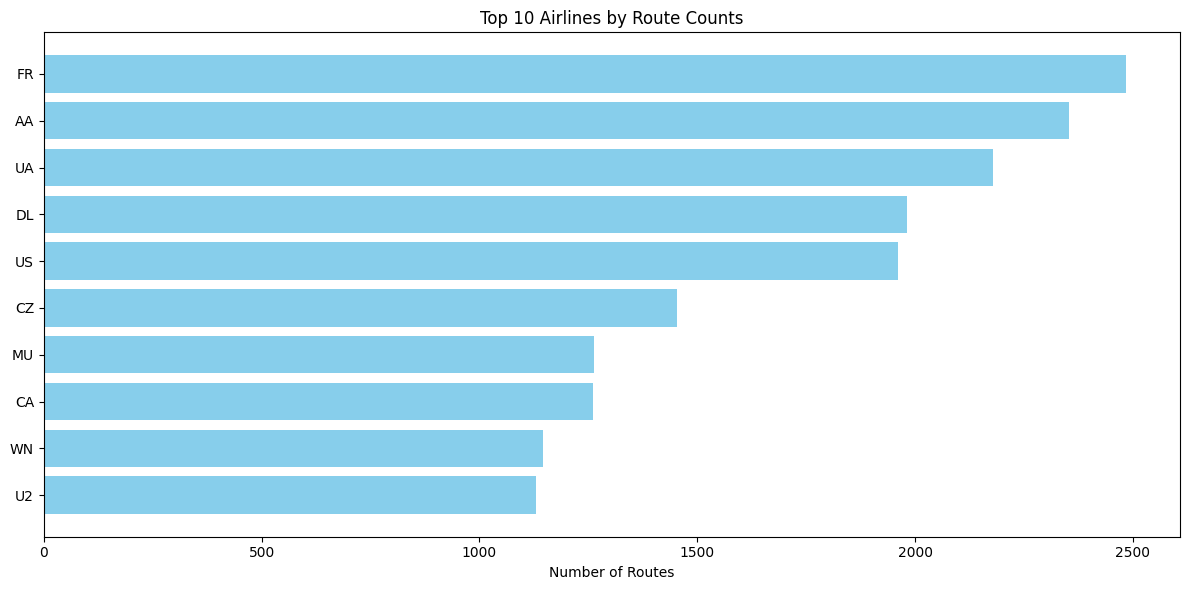

In [ ]:
# Group by airline and count number of routes
airline_routes = clean_routes.groupby('airline').size().reset_index(name='route_count')

# Sort descending to find top airlines
top_airlines = airline_routes.sort_values(by='route_count', ascending=False).head(10)

# Save to CSV
top_airlines.to_csv('top_airlines_by_routes.csv', index=False)



# Display result
print(tabulate(top_airlines, headers='keys', tablefmt='pretty'))



#Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_airlines['airline'], top_airlines['route_count'], color='skyblue')
plt.xlabel("Number of Routes")
plt.title("Top 10 Airlines by Route Counts")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [365]:
doc.add_heading("Airline and Routes Count", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(top_airlines.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in top_airlines.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")

PermissionError: [Errno 13] Permission denied: 'EDA_Report.docx'

#### Find busiest airports by number of connections


Top 10 Busiest Airports by Number of Connections:

+------+-----------+--------------------------------------------------+----------------+-------------+
|      | IATA Code |                   Airport Name                   |    Country     | Connections |
+------+-----------+--------------------------------------------------+----------------+-------------+
| 165  |    ATL    | Hartsfield Jackson Atlanta International Airport | United States  |    1826     |
| 2128 |    ORD    |       Chicago O'Hare International Airport       | United States  |    1108     |
| 2200 |    PEK    |      Beijing Capital International Airport       |     China      |    1069     |
| 1626 |    LHR    |             London Heathrow Airport              | United Kingdom |    1051     |
| 463  |    CDG    |     Charles de Gaulle International Airport      |     France     |    1041     |
| 890  |    FRA    |            Frankfurt am Main Airport             |    Germany     |     990     |
| 1573 |    LAX    | 

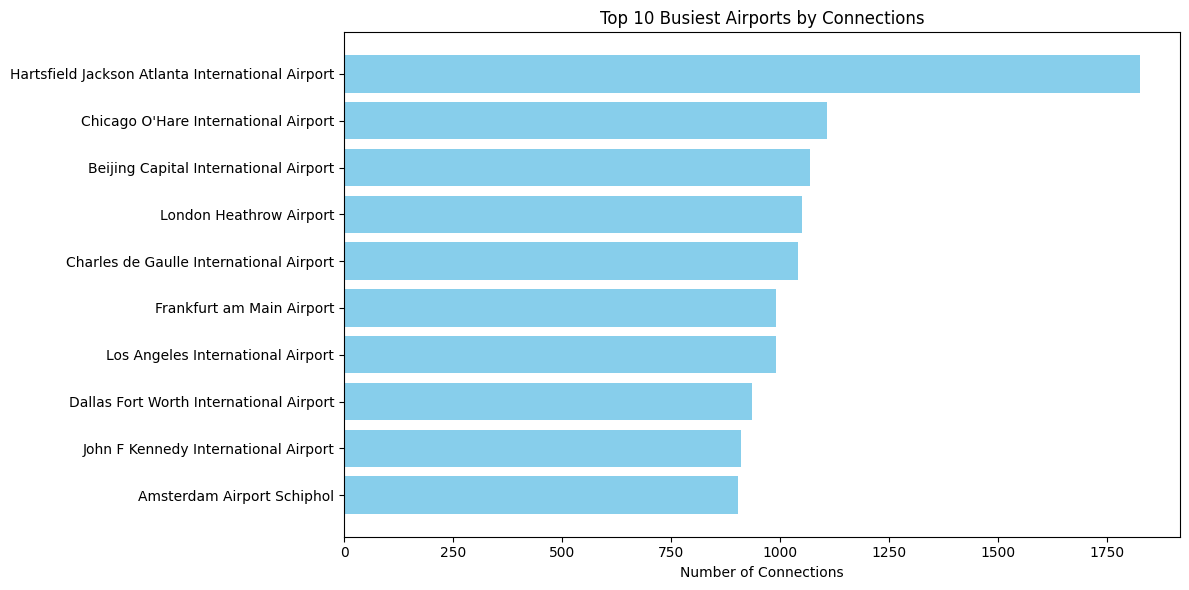

In [ ]:
# Calculate connection counts (outbound + inbound routes)
connection_counts = clean_routes['source_airport'].value_counts() + clean_routes['dest_airport'].value_counts()
connection_counts = connection_counts.groupby(connection_counts.index).sum()

# Convert to DataFrame
connection_df = connection_counts.reset_index()
connection_df.columns = ['airport_code', 'connection_count']

# Merge with airports to get names and countries
busiest_airports = pd.merge(connection_df, clean_airports, how='left', left_on='airport_code', right_on='iata')

# Select relevant columns
busiest_airports = busiest_airports[['airport_code', 'name', 'country', 'connection_count']]

# Drop missing names (optional)
busiest_airports = busiest_airports.dropna(subset=['name'])

# Round and sort
busiest_airports['connection_count'] = busiest_airports['connection_count'].round(0).astype(int)
busiest_airports = busiest_airports.sort_values(by='connection_count', ascending=False).head(10)

# Rename columns for clarity
busiest_airports = busiest_airports.rename(columns={
    'airport_code': 'IATA Code',
    'name': 'Airport Name',
    'country': 'Country',
    'connection_count': 'Connections'
})

# Display
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)
print("\nTop 10 Busiest Airports by Number of Connections:\n")
print(tabulate(busiest_airports, headers='keys', tablefmt='pretty'))

#Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(busiest_airports['Airport Name'], busiest_airports['Connections'], color='skyblue')
plt.xlabel("Number of Connections")
plt.title("Top 10 Busiest Airports by Connections")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [146]:
doc.add_heading("Top Ten Busiest Airports by Connections", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(busiest_airports.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in busiest_airports.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")

DOCX file saved as EDA_Report.docx


In [125]:
# Frequency of airports per country
airport_counts = clean_airports['country'].value_counts().reset_index()
airport_counts.columns = ['Country', 'Number of Airports']
freq_airports = airport_counts.head(10)  # Top 10 countries with most airports
print(tabulate(freq_airports, headers='keys', tablefmt='pretty'))

+---+----------------+--------------------+
|   |    Country     | Number of Airports |
+---+----------------+--------------------+
| 0 | United States  |        1503        |
| 1 |     Canada     |        428         |
| 2 |   Australia    |        328         |
| 3 |     Brazil     |        260         |
| 4 |     Russia     |        251         |
| 5 |    Germany     |        248         |
| 6 |     France     |        217         |
| 7 |     China      |        207         |
| 8 | United Kingdom |        165         |
| 9 |     India      |        145         |
+---+----------------+--------------------+


In [147]:
doc.add_heading("Top 10 Countries by Airport Count", level=0)

# Convert .describe() output to list of rows (include column names)
columns = [''] + list(freq_airports.columns)
data = [columns]

# Add rows: index as first column (e.g., count, mean, std...)
for index, row in freq_airports.iterrows():
    data.append([index] + list(row.values))

# Add the table to the document
table = doc.add_table(rows=len(data), cols=len(data[0]))
table.style = 'Table Grid'

# Fill the table cells
for i, row in enumerate(data):
    for j, val in enumerate(row):
        cell = table.cell(i, j)
        cell.text = f"{val:.2f}" if isinstance(val, float) else str(val)

# Save the document
doc.save("EDA_Report.docx")
print("DOCX file saved as EDA_Report.docx")

DOCX file saved as EDA_Report.docx


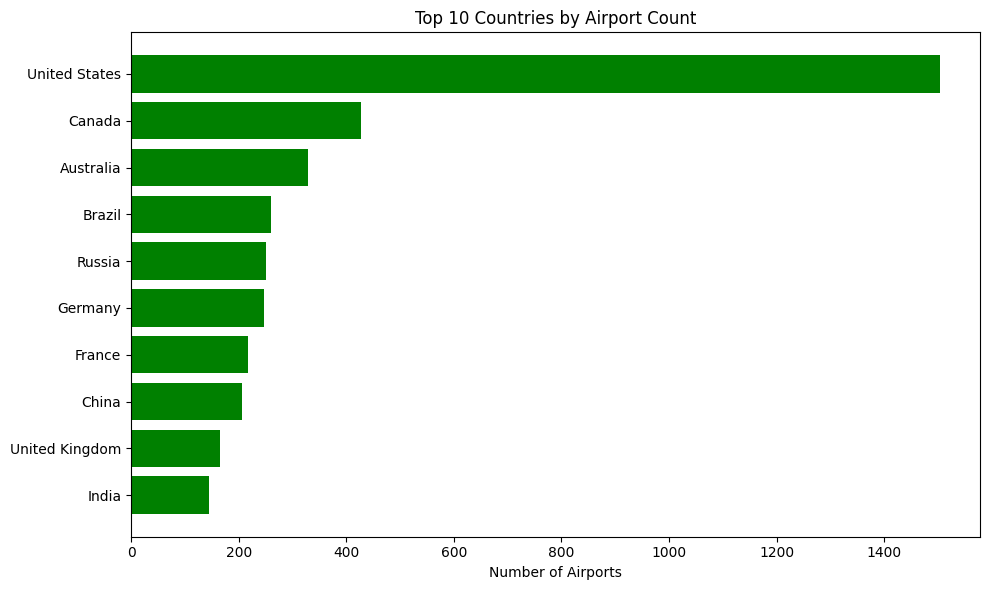

In [129]:
top_countries = airport_counts.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_countries['Country'], top_countries['Number of Airports'], color='green')
plt.xlabel("Number of Airports")
plt.title("Top 10 Countries by Airport Count")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Analyze geographic distribution of airports and routes

In [333]:

fig = px.scatter_geo(
    clean_airports,
    lat='latitude',
    lon='longitude',
    hover_name='name',
    color='country',  # Ensure this column has varied values
    title='Global Airport Locations',
    projection='natural earth',
    template='presentation',  # Optional: for better visibility
)
fig.show()



In [334]:
# Count routes from each source airport
route_counts = clean_routes['source_airport'].value_counts().reset_index()
route_counts.columns = ['IATA', 'Number of Routes']

# Merge with airports to get coordinates
airport_route_density = pd.merge(airports, route_counts, left_on='iata', right_on='IATA', how='inner')

# Plot density
fig = px.scatter_geo(airport_route_density, 
                     lat='latitude', lon='longitude',
                     size='Number of Routes', color='country',
                     hover_name='name',
                     title='Airport Route Density Map',
                     projection='natural earth',
                    template = 'presentation')
fig.show()


#### Examine airline activity status and country distribution

Airline Activity Status:
active
N    4906
Y    1253
n       1
Name: count, dtype: int64


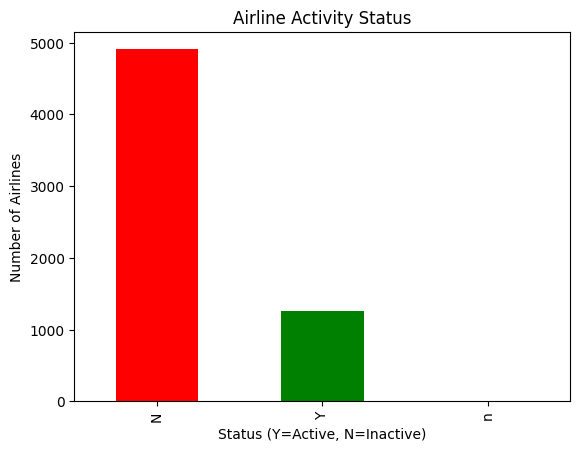

In [335]:
# Frequency distribution of airline activity
activity_counts = clean_airlines['active'].value_counts()

print("Airline Activity Status:")
print(activity_counts)

# Bar plot
activity_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Airline Activity Status')
plt.xlabel('Status (Y=Active, N=Inactive)')
plt.ylabel('Number of Airlines')
plt.show()


#### Top 10 Countries by Number of Airlines

Top 10 Countries by Number of Airlines:
country
United States     1099
Mexico             440
United Kingdom     414
Canada             323
Russia             238
Spain              168
Germany            135
France             123
Australia           94
Italy               93
Name: count, dtype: int64


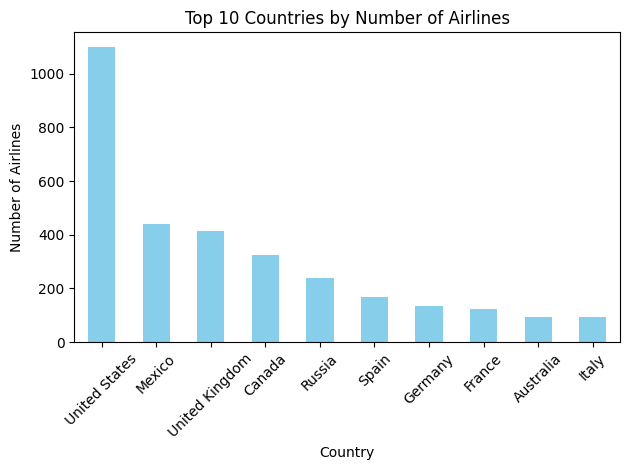

In [336]:
# Frequency distribution of airlines by country
country_counts = clean_airlines['country'].value_counts().head(10)

print("Top 10 Countries by Number of Airlines:")
print(country_counts)

# Bar plot
country_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Number of Airlines')
plt.xlabel('Country')
plt.ylabel('Number of Airlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Data Integration and Relationship Mapping 

#### Handle orphaned records (routes without corresponding airlines/airports)

In [337]:
# Validate airline_id in routes exists in airlines
invalid_airlines = clean_routes[~clean_routes['airline_id'].isin(clean_airlines['airline_id'])]
print(f"Invalid airline references: {len(invalid_airlines)}")

# Validate source_airport_id exists in airports
invalid_source = clean_routes[~clean_routes['source_airport_id'].isin(clean_airports['airport_id'])]
print(f"Invalid source airport references: {len(invalid_source)}")

# Validate dest_airport_id exists in airports
invalid_dest = clean_routes[~clean_routes['dest_airport_id'].isin(clean_airports['airport_id'])]
print(f"Invalid destination airport references: {len(invalid_dest)}")


Invalid airline references: 479
Invalid source airport references: 827
Invalid destination airport references: 831


#### Create master dataset by joining all three tables

In [338]:
# Step 2: Validate foreign keys (only keep valid rows in routes)
valid_airline_ids = clean_airlines['airline_id'].unique()
valid_airport_ids = clean_airports['airport_id'].unique()

# Filter clean_routes to create valid_routes
valid_routes = clean_routes[
    (clean_routes['airline_id'].isin(valid_airline_ids)) &
    (clean_routes['source_airport_id'].isin(valid_airport_ids)) &
    (clean_routes['dest_airport_id'].isin(valid_airport_ids))
]

# Step 3: Merge valid_routes with airlines to add airline info
routes_with_airlines = pd.merge(valid_routes, clean_airlines, on='airline_id', suffixes=('', '_airline'))

# Step 4: Merge with source airport info
routes_with_source = pd.merge(routes_with_airlines, clean_airports, left_on='source_airport_id', right_on='airport_id', suffixes=('', '_source'))

# Step 5: Merge with destination airport info
master_dataset = pd.merge(routes_with_source, clean_airports, left_on='dest_airport_id', right_on='airport_id', suffixes=('', '_dest'))

# Step 6: Save master dataset
master_dataset.to_csv("master_dataset.csv", index=False)


print("Master dataset created successfully.")

Master dataset created successfully.


In [339]:
# Drop duplicate airline_id rows, keeping the first occurrence
master_dataset_unique = master_dataset.drop_duplicates(subset=['icao', 'longitude', 'latitude', 'altitude'], keep='first')

# Confirm the result
print(f"Original rows: {len(master_dataset)}")
print(f"Rows after removing duplicates: {len(master_dataset_unique)}")

# Save the updated master dataset (after dropping duplicates) to a new CSV file
master_dataset_unique.to_csv("clean_master_dataset.csv", index=False)



Original rows: 65648
Rows after removing duplicates: 18303


In [340]:
# Optional: Preview the master dataset
master_dataset

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment,name,icao,...,iata_dest,icao_dest,latitude_dest,longitude_dest,altitude_dest,timezone_dest,dst_dest,tz_name_dest,type_dest,source_dest
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
2,2B,410.0,ASF,2966.0,MRV,2962.0,0,CR2,Aerocondor,ARD,...,MRV,URMM,44.225101,43.081902,1054,3.0,N,Europe/Moscow,airport,OurAirports
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
4,2B,410.0,CEK,2968.0,OVB,4078.0,0,CR2,Aerocondor,ARD,...,OVB,UNNT,55.012600,82.650703,365,7.0,N,Asia/Krasnoyarsk,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65643,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3,Regional Express,RXA,...,ADL,YPAD,-34.945000,138.531006,20,9.5,O,Australia/Adelaide,airport,OurAirports
65644,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734,Apache Air,IWA,...,FRU,UAFM,43.061298,74.477600,2058,6.0,U,Asia/Bishkek,airport,OurAirports
65645,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734,Apache Air,IWA,...,DME,UUDD,55.408798,37.906300,588,3.0,N,Europe/Moscow,airport,OurAirports
65646,ZM,19016.0,FRU,2912.0,OSS,2913.0,0,734,Apache Air,IWA,...,OSS,UAFO,40.609001,72.793297,2927,6.0,U,Asia/Bishkek,airport,OurAirports


In [341]:
master_dataset_unique

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment,name,icao,...,iata_dest,icao_dest,latitude_dest,longitude_dest,altitude_dest,timezone_dest,dst_dest,tz_name_dest,type_dest,source_dest
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
5,2B,410.0,DME,4029.0,KZN,2990.0,0,CR2,Aerocondor,ARD,...,KZN,UWKD,55.606201,49.278702,411,3.0,N,Europe/Moscow,airport,OurAirports
8,2B,410.0,EGO,6156.0,KGD,2952.0,0,CR2,Aerocondor,ARD,...,KGD,UMKK,54.889999,20.592600,42,2.0,N,Europe/Kaliningrad,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65641,ZL,4178.0,WIN,6337.0,LRE,6289.0,0,SF3,Regional Express,RXA,...,LRE,YLRE,-23.434200,144.279999,627,10.0,O,Australia/Brisbane,airport,OurAirports
65643,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3,Regional Express,RXA,...,ADL,YPAD,-34.945000,138.531006,20,9.5,O,Australia/Adelaide,airport,OurAirports
65644,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734,Apache Air,IWA,...,FRU,UAFM,43.061298,74.477600,2058,6.0,U,Asia/Bishkek,airport,OurAirports
65645,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734,Apache Air,IWA,...,DME,UUDD,55.408798,37.906300,588,3.0,N,Europe/Moscow,airport,OurAirports


#### Create lookup dictionaries for efficient querying

In [342]:
# Airline and Airport lookup with country info
airlines_lookup_dict = clean_airlines.set_index('airline_id')[['name', 'country']].to_dict(orient='index')
airports_lookup_dict = clean_airports.set_index('airport_id')[['name', 'country']].to_dict(orient='index')


In [343]:
for i, (key,value) in enumerate(airlines_lookup_dict.items()):
    if i>=10:
        break
    else:
        print(f'{key}:{value}')


2:{'name': '135 Airways', 'country': 'United States'}
3:{'name': '1Time Airline', 'country': 'South Africa'}
4:{'name': '2 Sqn No 1 Elementary Flying Training School', 'country': 'United Kingdom'}
5:{'name': '213 Flight Unit', 'country': 'Russia'}
6:{'name': '223 Flight Unit State Airline', 'country': 'Russia'}
7:{'name': '224th Flight Unit', 'country': 'Russia'}
8:{'name': '247 Jet Ltd', 'country': 'United Kingdom'}
9:{'name': '3D Aviation', 'country': 'United States'}
10:{'name': '40-Mile Air', 'country': 'United States'}
11:{'name': '4D Air', 'country': 'Thailand'}


In [345]:
for i, (key,value) in enumerate(airports_lookup_dict.items()):
    if i>=10:
        break
    else:
        print(f'{key}:{value}')



1:{'name': 'Goroka Airport', 'country': 'Papua New Guinea'}
2:{'name': 'Madang Airport', 'country': 'Papua New Guinea'}
3:{'name': 'Mount Hagen Kagamuga Airport', 'country': 'Papua New Guinea'}
4:{'name': 'Nadzab Airport', 'country': 'Papua New Guinea'}
5:{'name': 'Port Moresby Jacksons International Airport', 'country': 'Papua New Guinea'}
6:{'name': 'Wewak International Airport', 'country': 'Papua New Guinea'}
7:{'name': 'Narsarsuaq Airport', 'country': 'Greenland'}
8:{'name': 'Godthaab / Nuuk Airport', 'country': 'Greenland'}
9:{'name': 'Kangerlussuaq Airport', 'country': 'Greenland'}
10:{'name': 'Thule Air Base', 'country': 'Greenland'}


## Advanced Analysis and Insights

### Network Analysis

Graph has 5959 nodes and 18668 edges.


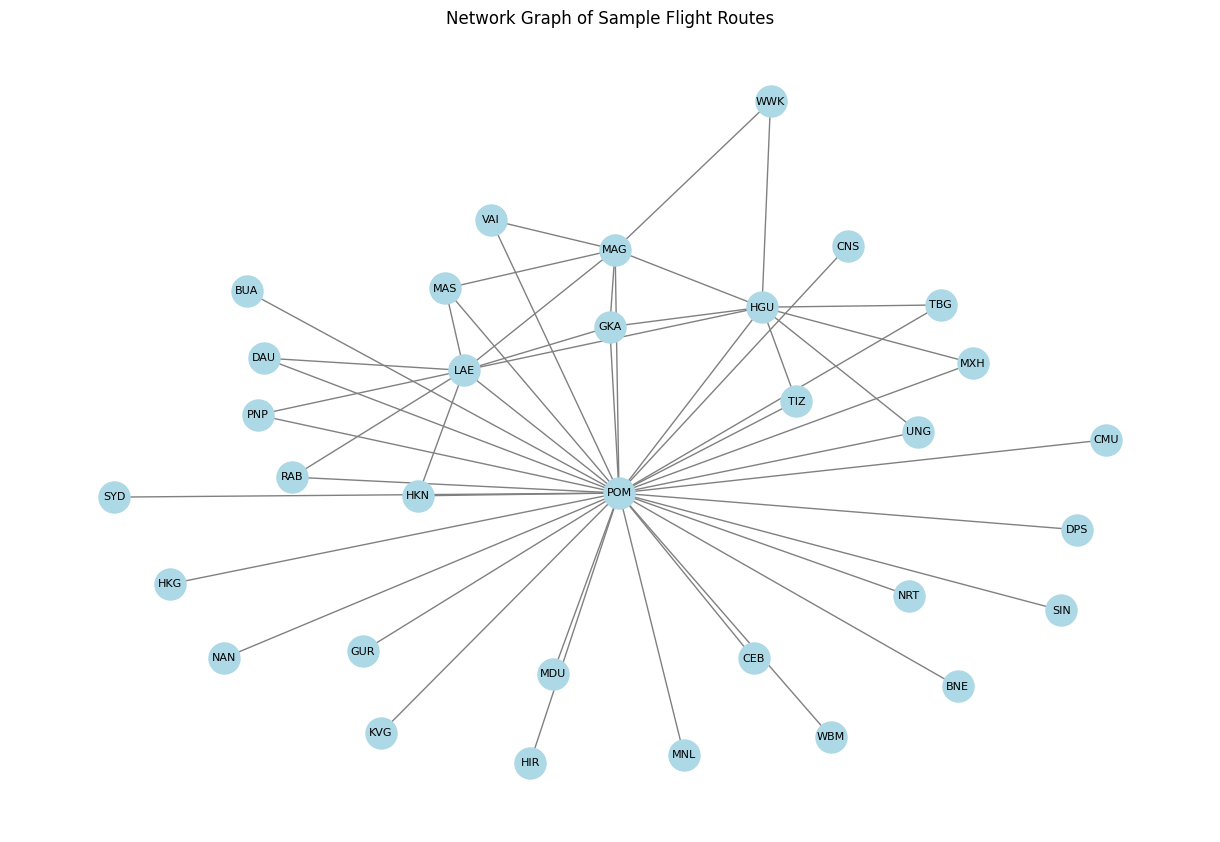

In [372]:
# Create an empty undirected graph
G = nx.Graph()

# STEP 1: Add airport nodes with attributes
for _, row in clean_airports.iterrows():
    G.add_node(row['iata'], 
               name=row['name'], 
               country=row['country'], 
               latitude=row['latitude'], 
               longitude=row['longitude'])

# STEP 2: Add route edges with attributes
for _, row in clean_routes.iterrows():
    source = row['source_airport']
    dest = row['dest_airport']
    distance = row.get('distance_km', 1)  # Default to 1 if distance not present
    frequency = row.get('frequency', 1)   # Optional: if frequency data exists

    # Only add the edge if both airports are in the graph
    if G.has_node(source) and G.has_node(dest):
        G.add_edge(source, dest, weight=distance, frequency=frequency)

# Optional: Print summary of the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


# Visualize a small subset (e.g., top 50 routes)
subset_edges = list(G.edges())[:50]
subset_G = G.edge_subgraph(subset_edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subset_G)
nx.draw(subset_G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', font_size=8)
plt.title("Network Graph of Sample Flight Routes")
plt.show()

# Graph saved
nx.write_gml(G, "airport_network.gml")

In [347]:
# Create a directed graph
G = nx.DiGraph()

# Add airport nodes with attributes
for _, row in clean_airports.iterrows():
    G.add_node(row['iata'],
               name=row['name'],
               country=row['country'],
               latitude=row['latitude'],
               longitude=row['longitude'])

# Add route edges with distance and frequency as attributes
for _, row in clean_routes.iterrows():
    source = row['source_airport']
    dest = row['dest_airport']
    distance = row.get('distance_km', 1)
    frequency = row.get('frequency', 1)

    if G.has_node(source) and G.has_node(dest):
        G.add_edge(source, dest, weight=distance, frequency=frequency)

print(f"Directed graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")







Directed graph: 5959 nodes and 36528 edges.


+------+---------+--------------------------------------------------+----------------------+-----------------------+
|      | Airport |                       name                       |       country        |       PageRank        |
+------+---------+--------------------------------------------------+----------------------+-----------------------+
| 4454 |   ATL   | Hartsfield Jackson Atlanta International Airport |    United States     | 0.0043463193870810065 |
| 2857 |   IST   |          Atatürk International Airport           |        Turkey        | 0.0040005030193294155 |
| 4596 |   ORD   |       Chicago O'Hare International Airport       |    United States     | 0.0039763925648884394 |
| 4521 |   DEN   |           Denver International Airport           |    United States     | 0.0039048722372551853 |
| 4442 |   DFW   |     Dallas Fort Worth International Airport      |    United States     | 0.003897587719570786  |
| 4771 |   DME   |         Domodedovo International Airport     

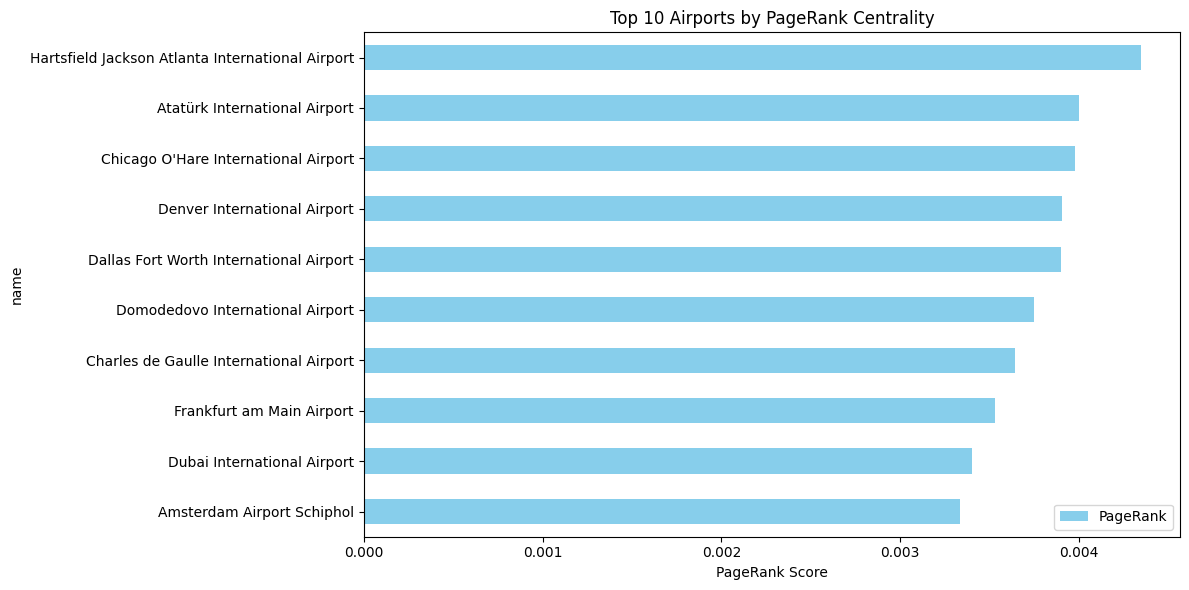

In [348]:
# Degree Centrality (how many connections in/out)
degree_centrality = nx.degree_centrality(G)

# Closeness Centrality (how close a node is to all others)
closeness_centrality = nx.closeness_centrality(G)

# PageRank (importance of nodes based on link structure)
pagerank = nx.pagerank(G, alpha=0.85)

# Combine into a DataFrame
centrality_df = pd.DataFrame({
    'Airport': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'PageRank': list(pagerank.values())
})

# Merge with airport names
centrality_df = centrality_df.merge(clean_airports[['iata', 'name', 'country']],
                                    left_on='Airport', right_on='iata').drop(columns=['iata'])

# Show top 10 airports by PageRank
top_airports = centrality_df.sort_values(by='PageRank', ascending=False).head(10)
print(tabulate(top_airports[['Airport', 'name', 'country', 'PageRank']], headers='keys', tablefmt='pretty'))

top_10 = top_airports[['name', 'PageRank']].set_index('name')

centrality_df.to_csv("network_centrality_metrics.csv", index=False)


top_10.plot(kind='barh', color='skyblue', figsize=(12, 6))
plt.xlabel("PageRank Score")
plt.title("Top 10 Airports by PageRank Centrality")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [349]:
import numpy as np


# Create lookup dictionaries for latitude and longitude
airport_coords = clean_airports.set_index('airport_id')[['latitude', 'longitude']].to_dict(orient='index')

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Calculate distance for each route
distances = []
for _, row in clean_routes.iterrows():
    src_id = row['source_airport_id']
    dst_id = row['dest_airport_id']
    try:
        src = airport_coords[src_id]
        dst = airport_coords[dst_id]
        distance = haversine(src['latitude'], src['longitude'], dst['latitude'], dst['longitude'])
    except KeyError:
        distance = np.nan  # Missing airport data
    distances.append(distance)

routes['distance_km'] = distances

# Drop rows with missing distance
routes = routes.dropna(subset=['distance_km'])

# Save to CSV
routes.to_csv("routes_with_distance.csv", index=False)
print("Saved routes_with_distance.csv with calculated distances.")


Saved routes_with_distance.csv with calculated distances.


In [350]:
# Filter active airports
airports = clean_airports[airports['iata'].notnull()]
airports = airports[['iata', 'latitude', 'longitude', 'name', 'country']]

# Merge to get coordinates for source and destination
routes = clean_routes.merge(airports, left_on='source_airport', right_on='iata', how='left')
routes.rename(columns={'latitude': 'source_lat', 'longitude': 'source_lon'}, inplace=True)
routes.drop('iata', axis=1, inplace=True)

routes = routes.merge(airports, left_on='dest_airport', right_on='iata', how='left')
routes.rename(columns={'latitude': 'dest_lat', 'longitude': 'dest_lon'}, inplace=True)
routes.drop('iata', axis=1, inplace=True)
routes.rename(columns={'airline': 'airline_name'}, inplace=True)

# Calculate distance
def calc_distance(row):
    if pd.notnull(row['source_lat']) and pd.notnull(row['dest_lat']):
        coord1 = (row['source_lat'], row['source_lon'])
        coord2 = (row['dest_lat'], row['dest_lon'])
        return geodesic(coord1, coord2).km
    else:
        return None

routes['distance_km'] = routes.apply(calc_distance, axis=1)

# Save cleaned and enriched routes file
routes.to_csv("routes_with_distance.csv", index=False)
print("routes_with_distance.csv generated.")


routes_with_distance.csv generated.


In [351]:
rd = pd.read_csv('routes_with_distance.csv')
rd

,airline_name,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,stops,equipment,source_lat,source_lon,name_x,country_x,dest_lat,dest_lon,name_y,country_y,distance_km
0,2B,410.0,AER,2965.0,KZN,2990.0,0,CR2,43.449902,39.956600,Sochi International Airport,Russia,55.606201,49.278702,Kazan International Airport,Russia,1507.989680
1,2B,410.0,ASF,2966.0,KZN,2990.0,0,CR2,46.283298,48.006302,Astrakhan Airport,Russia,55.606201,49.278702,Kazan International Airport,Russia,1040.943207
2,2B,410.0,ASF,2966.0,MRV,2962.0,0,CR2,46.283298,48.006302,Astrakhan Airport,Russia,44.225101,43.081902,Mineralnyye Vody Airport,Russia,449.036664
3,2B,410.0,CEK,2968.0,KZN,2990.0,0,CR2,55.305801,61.503300,Chelyabinsk Balandino Airport,Russia,55.606201,49.278702,Kazan International Airport,Russia,773.126239
4,2B,410.0,CEK,2968.0,OVB,4078.0,0,CR2,55.305801,61.503300,Chelyabinsk Balandino Airport,Russia,55.012600,82.650703,Tolmachevo Airport,Russia,1343.161121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67658,ZL,4178.0,WYA,6334.0,ADL,3341.0,0,SF3,-33.058899,137.514008,Whyalla Airport,Australia,-34.945000,138.531006,Adelaide International Airport,Australia,229.334784
67659,ZM,19016.0,DME,4029.0,FRU,2912.0,0,734,55.408798,37.906300,Domodedovo International Airport,Russia,43.061298,74.477600,Manas International Airport,Kyrgyzstan,2949.906100
67660,ZM,19016.0,FRU,2912.0,DME,4029.0,0,734,43.061298,74.477600,Manas International Airport,Kyrgyzstan,55.408798,37.906300,Domodedovo International Airport,Russia,2949.906100
67661,ZM,19016.0,FRU,2912.0,OSS,2913.0,0,734,43.061298,74.477600,Manas International Airport,Kyrgyzstan,40.609001,72.793297,Osh Airport,Kyrgyzstan,306.189294


In [352]:
def assign_region(country):
    for region, countries in region_map.items():
        if country in countries:
            return region
    return 'Other'

# Step 1: Count routes per airline
airline_route_counts = routes.groupby('airline_name').agg({
    'source_airport': 'count',
    'distance_km': 'mean'
}).reset_index()
airline_route_counts.columns = ['airline_name', 'route_count', 'avg_distance_km']

# Step 2: Add airline ID
airline_ids = routes[['airline_name', 'airline_id']].drop_duplicates()
airline_market = pd.merge(airline_route_counts, airline_ids, on='airline_name', how='left')

# Step 3: Assign region based on source airport's country

# Drop previous merge artifacts if any
routes = routes.drop(columns=[col for col in routes.columns if col in ['country_x', 'country_y', 'iata']], errors='ignore')

# Clean and standardize airport codes
routes['source_airport'] = routes['source_airport'].astype(str).str.strip().str.upper()
clean_airports['iata'] = clean_airports['iata'].astype(str).str.strip().str.upper()

# Prepare airport info for merge
airport_info = clean_airports[['iata', 'country']]

# Merge to get country for source airport
routes = pd.merge(routes, airport_info, left_on='source_airport', right_on='iata', how='left')

# Check for successful merge
if 'country' not in routes.columns:
    raise KeyError("'country' column missing after merge. Merge failed.")

# Rename for clarity
routes.rename(columns={'country': 'source_country'}, inplace=True)

# Region mapping
region_map = {
    'North America': ['United States', 'Canada', 'Mexico'],
    'Europe': ['United Kingdom', 'Germany', 'France', 'Italy', 'Spain'],
    'Asia': ['China', 'India', 'Japan', 'Singapore', 'UAE'],
    'Africa': ['South Africa', 'Nigeria', 'Egypt'],
    'South America': ['Brazil', 'Argentina', 'Chile'],
    'Oceania': ['Australia', 'New Zealand']
}

# Assign region
routes['region'] = routes['source_country'].apply(assign_region)

# Step 4: Aggregate region info per airline
region_per_airline = routes.groupby('airline_name')['region'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else 'Other'
).reset_index()

# Merge into market data
airline_market = pd.merge(airline_market, region_per_airline, on='airline_name', how='left')

# Step 5: Save to CSV
airline_market.to_csv("airline_market_share.csv", index=False)
print("airline_market_share.csv generated.")


airline_market_share.csv generated.


In [353]:


# Group by route (source + destination), count unique airlines
route_competition = clean_routes.groupby(['source_airport', 'dest_airport'])['airline'].nunique().reset_index()
route_competition.columns = ['source_airport', 'dest_airport', 'num_airlines']

# Filter for competitive routes (e.g., 2 or more airlines serve it)
competitive_routes = route_competition[route_competition['num_airlines'] >= 2]

# Sort by most competitive
competitive_routes = competitive_routes.sort_values(by='num_airlines', ascending=False)

# Optional: Add average distance per route
routes_with_distance = pd.read_csv("routes_with_distance.csv")
avg_dist = routes_with_distance.groupby(['source_airport', 'dest_airport'])['distance_km'].mean().reset_index()
competitive_routes = competitive_routes.merge(avg_dist, on=['source_airport', 'dest_airport'], how='left')

# Save to CSV
competitive_routes.to_csv("competitive_routes.csv", index=False)
print("Saved competitive_routes.csv")


Saved competitive_routes.csv


In [354]:
# Merge airport names with routes for both source and destination
airports_small = clean_airports[['airport_id', 'city', 'country']].copy()

# Merge source airport city
routes = clean_routes.merge(airports_small, how='left', left_on='source_airport_id', right_on='airport_id')
routes = routes.rename(columns={'city': 'source_city', 'country': 'source_country'})
routes.drop('airport_id', axis=1, inplace=True)

# Merge destination airport city
routes = routes.merge(airports_small, how='left', left_on='dest_airport_id', right_on='airport_id')
routes = routes.rename(columns={'city': 'dest_city', 'country': 'dest_country'})
routes.drop('airport_id', axis=1, inplace=True)

# Group by city pairs and count airlines
city_pairs = routes.groupby(['source_city', 'dest_city'])['airline'].nunique().reset_index()
city_pairs.columns = ['source_city', 'dest_city', 'num_airlines']

# Filter underserved routes (1 or no airline)
underserved = city_pairs[city_pairs['num_airlines'] <= 1]

# Sort for clarity
underserved = underserved.sort_values(by='num_airlines')

# Save to CSV
underserved.to_csv("underserved_city_pairs.csv", index=False)
print("Saved underserved_city_pairs.csv")


Saved underserved_city_pairs.csv
